# 銘柄のテクニカル分析を学習する

In [175]:
import pandas as pd

def create_dataset(csvfile, input_field, predict_target="Value1", shift_size=5):
    # Timestamp + ELのFeatureSelectorで定義した特徴(oV1 〜 oVN)
    table_header = [
        "timestamp", 
        "Value1",
        "Value2",
        "Value3",
        "Value4",
        "Value5",
        "Value6",
        "Value7",
        "Value8",
        "Value9",
        "Value10",
        "Value11",
        "Value12",
        "Value13",
        "Value14",
        "Value15"
    ]
    # データフレームの読み込み
    df = pd.read_csv(csvfile, header=None, names=table_header)

    # 何マス先の未来を予測するか
    df[predict_target] = df[predict_target].shift(-shift_size)

    # shiftした結果 末尾がpredict_targetがNanとなるので削除する
    df = df[:-shift_size]

    # Dataサイズ
    data_len = len(df)

    # 教師データとテストデータを7:3で分割する
    train_data_rate = 0.2
    train_df = df[:int(data_len*train_data_rate)]
    test_df = df[int(data_len*train_data_rate):]

    #教師データ
    print(train_df.head())
    X = train_df[input_field].values
    Y = train_df[[predict_target]].values

    # テストデータ
    print(test_df.head())
    test_X = test_df[input_field].values
    test_Y = test_df[[predict_target]].values
    input_dim = len(input_field)
    return (X, Y, test_X, test_Y, df, input_dim)

In [34]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers.recurrent import LSTM

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# モデルの作成
def create_model(input_dim, activation="relu", optimizer="adam", nb_hidden=10, metrics=["accuracy"], loss='binary_crossentropy'):
    inputs = Input(shape=(input_dim,))
    x = Dense(nb_hidden, activation=activation)(inputs)
    x = Dropout(0.15)(x)
    updown = Dense(1, activation='sigmoid', name='updown')(x)
    model = Model(inputs=inputs, outputs=updown)
    model.compile(
        loss=loss, 
        optimizer=optimizer, 
        metrics=metrics
    )
    return model


In [54]:
# GridSearchを使ってパラメータを最適化する
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from livelossplot.keras import PlotLossesCallback

def gridsearch(X, Y, test_X, test_Y, input_dim):
    # https://keras.io/ja/activations/
    activations = ["relu", "tanh", "sigmoid", "linear", "softmax"]
    # https://keras.io/ja/optimizers/
    optimizer = ["adam", "adamax", "sgd"]
    nb_hiddens = np.array([50, 100, 300])
    nb_epoch = [10]
    
    param_grid = dict(
        activation=activations, 
        nb_hidden=nb_hiddens, 
        nb_epoch=nb_epoch,
        optimizer=optimizer,
        input_dim=[input_dim]
    )
    model = KerasClassifier(build_fn=create_model, verbose=0)
    grid = GridSearchCV(
        model,
        param_grid,
        verbose=1,
        n_jobs = -1,
        cv=3 # 3-fold Cross-Validationで評価 
    )

    grid_result = grid.fit(
        X, Y,
        validation_data = (test_X, test_Y),
    )

    return grid_result

In [201]:

# データセットの作成
from keras_tqdm import TQDMNotebookCallback
from livelossplot.keras import PlotLossesCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend import clear_session
from glob import glob

# Stock-AIのpredict関数の引数と合わせる
predict_target = "Value1"
input_field = [
    "Value1",
    "Value2",
    "Value3",
    "Value4",
    "Value5",
    "Value6",
    "Value7",
    "Value8",
    "Value9",
    "Value10",
    "Value11",
    "Value12",
    "Value13",
    "Value14",
    "Value15"
]
input_field.remove(predict_target)

csvdir = "dataset/csv"

def learn(csvfile):
    MODEL_DIR = "model"
    filesize = os.path.getsize(csvfile)
    print(f"load {csvfile} {filesize}")
    if filesize < 700:
        return
    symbolname, ext = os.path.splitext(os.path.basename(csvfile))
    model_file = os.path.join(MODEL_DIR, f"{symbolname}.h5")

    # データセットの準備
    X, Y, test_X, test_Y, df, input_dim = create_dataset(
        csvfile, 
        input_field, 
        predict_target=predict_target,
        shift_size=5
    )
    #print(df.head())
    try:
        # GridSearchで得られたパラメータを使ってモデルを作成
        grid_result = gridsearch(X, Y, test_X, test_Y, input_dim)
        grid_params = grid_result.best_params_
        #grid_params = {'activation': 'relu', 'input_dim': 14, 'nb_epoch': 100, 'nb_hidden': 50, 'optimizer': 'adam'}
        print("最適なパラメータは下記の通りです")
        print(grid_params)

        model = create_model(
            input_dim=input_dim,
            activation=grid_params['activation'],
            nb_hidden=grid_params['nb_hidden'],
            optimizer=grid_params['optimizer'],
            metrics=[
                'binary_accuracy', 
                'mae' # モデルの予測精度の"悪さ"を表すため、0 に近い値であるほど優れている。
            ]
        )
        model.fit(
              X, Y,
              validation_data = (test_X, test_Y),
              epochs=grid_params['nb_epoch'],
              verbose=0,
              callbacks=[
                  #PlotLossesCallback(),
                  ModelCheckpoint(monitor='val_loss', filepath="%s" % model_file),
                  #EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
              ]
        )
        score = model.evaluate(test_X, test_Y, verbose=0)
        print(f"field: {input_field} loss: {score[0]}, acc: {score[1]}, mae: {score[2]}")


    except Exception as e:
        print(e)
    # セッションのクリア
    clear_session()
        
for csvfile in sorted(glob(os.path.join(csvdir, "*.csv")), key=os.path.getsize, reverse=True):
    learn(csvfile)
#symbol = "9984"
#csvfile = f"dataset/csv/{symbol}-TS.csv"
#learn(csvfile)

load dataset/csv/9984-TS.csv 5024892
             timestamp    Value1      Value2    Value3  Value4  Value5  \
0  2016/11/22 11:10:00  0.687714  198.712446  0.306390     0.0     0.0   
1  2016/11/22 11:15:00  0.782913   48.000000  0.306122     0.0     0.0   
2  2016/11/22 11:20:00  0.804227  -28.015075  0.101892     0.0     0.0   
3  2016/11/22 11:25:00  0.825628  -14.788732  0.043674     0.0     0.0   
4  2016/11/22 11:30:00  0.846590  -17.037037 -0.029082     0.0     0.0   

   Value6  Value7  Value8  Value9  Value10  Value11  Value12  Value13  \
0     0.0     0.0     0.0     0.0    0.105      0.0      0.0      0.0   
1     0.0     0.0     0.0     0.0    0.000      1.0      0.0      0.0   
2     0.0     0.0     0.0     0.0    0.000      0.0      0.0      0.0   
3     0.0     0.0     0.0     0.0    0.000      0.0      0.0      0.0   
4     0.0     0.0     0.0     0.0    0.000      0.0      0.0      0.0   

   Value14  Value15  
0      0.0      0.0  
1      0.0      0.0  
2      0.0   

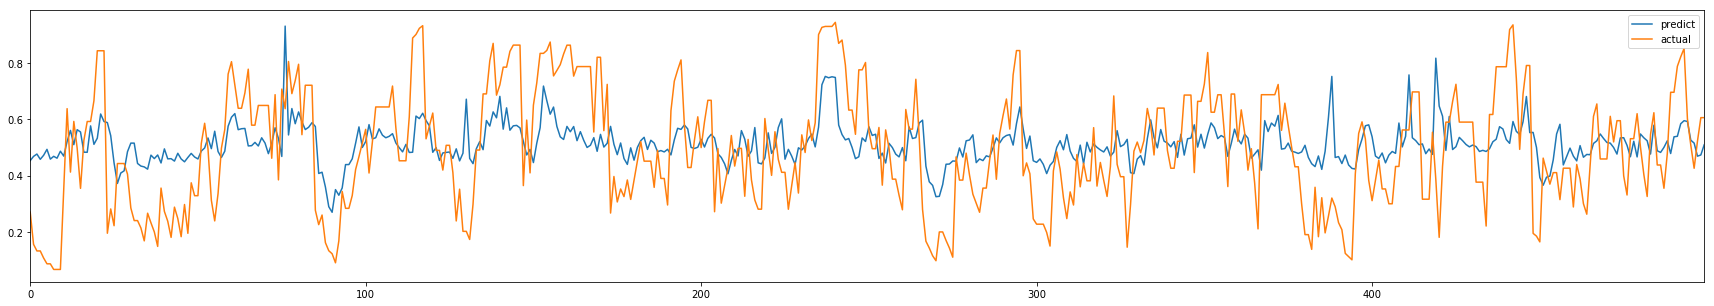

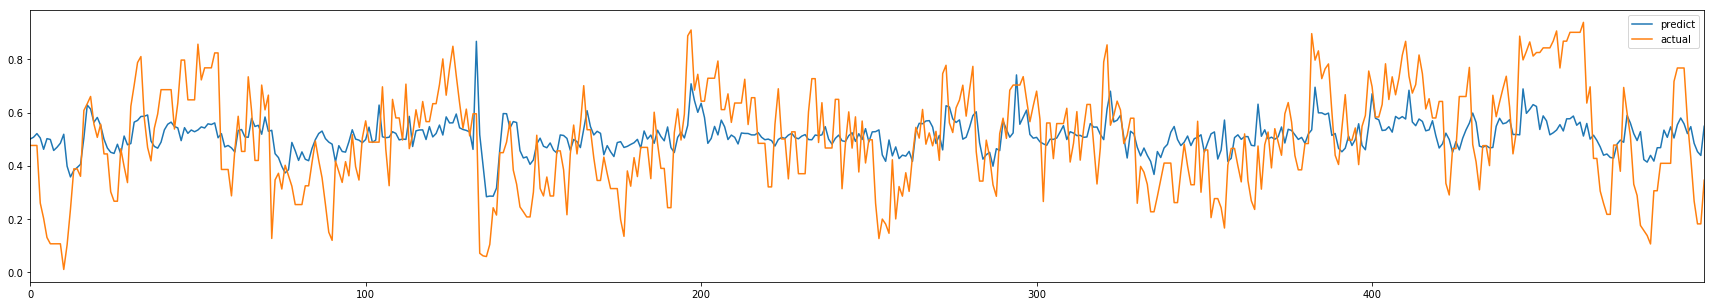

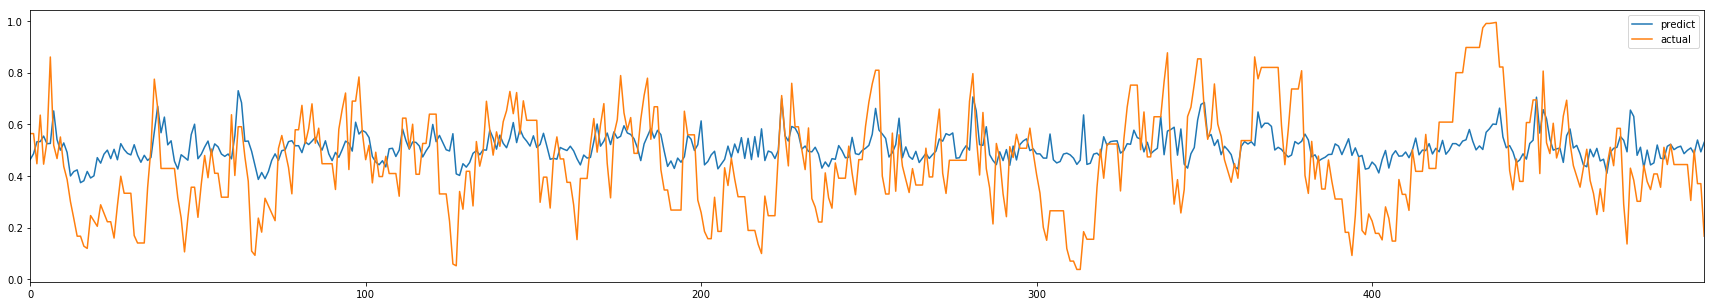

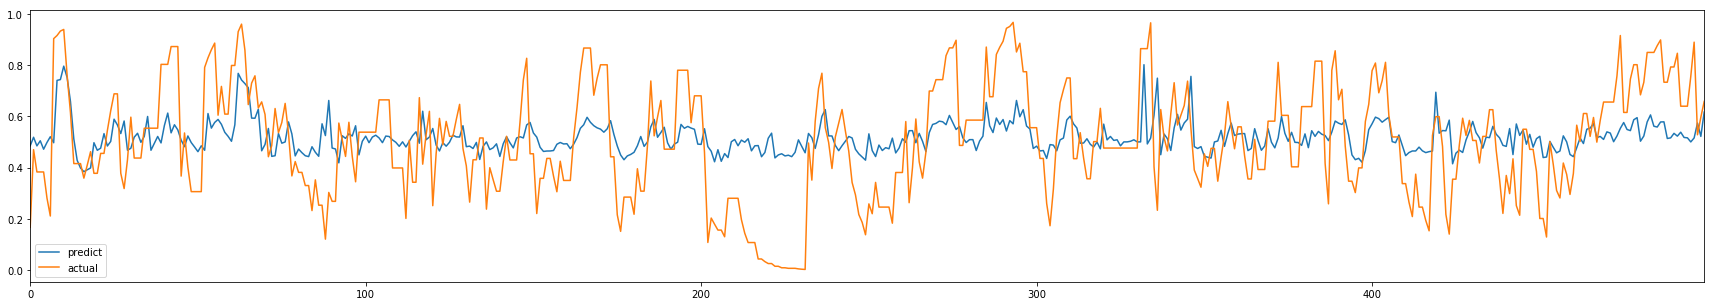

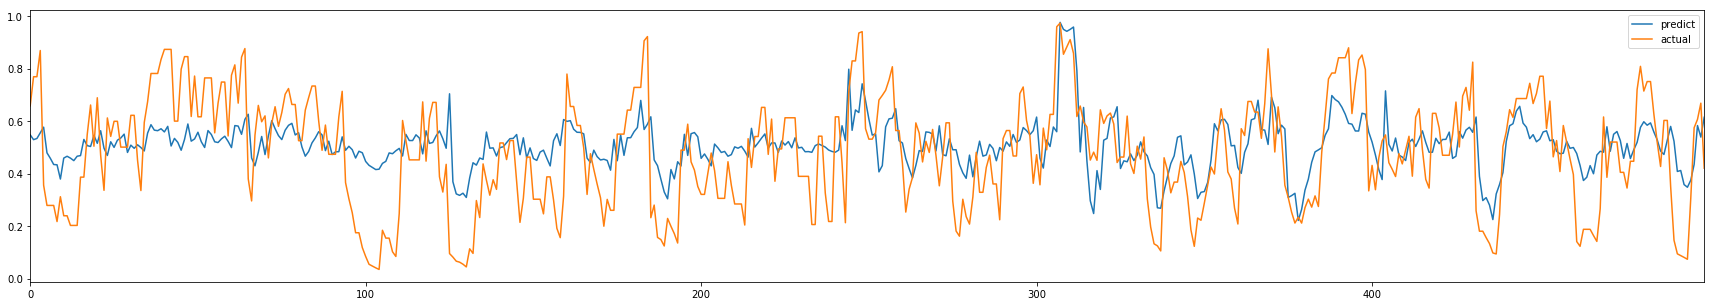

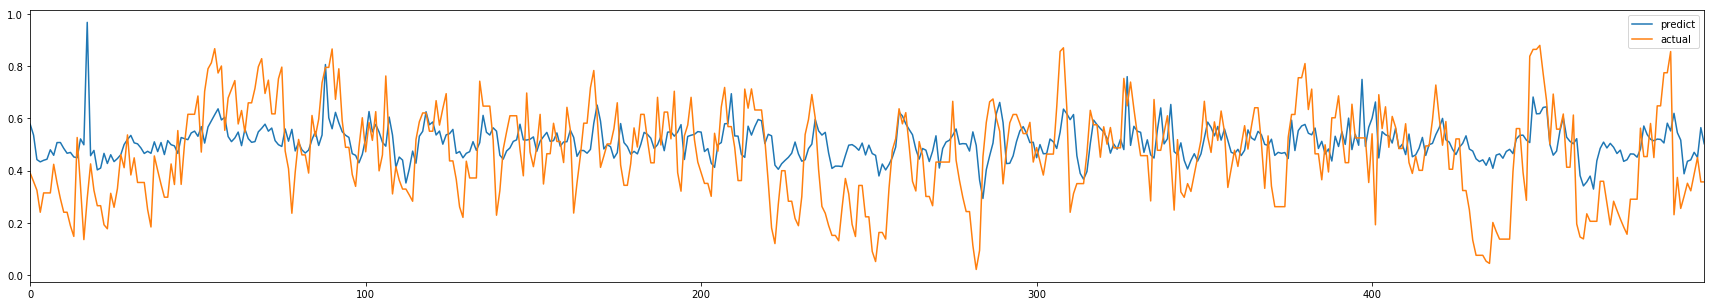

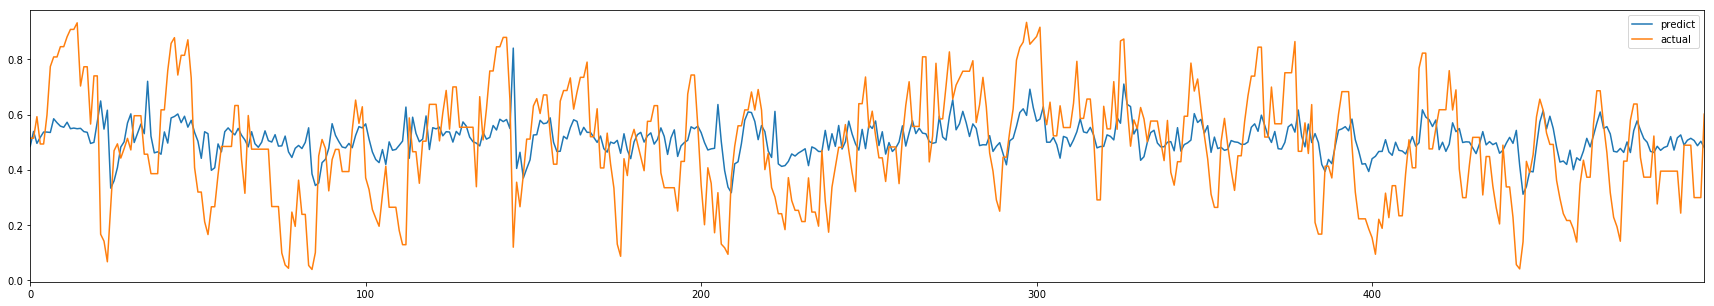

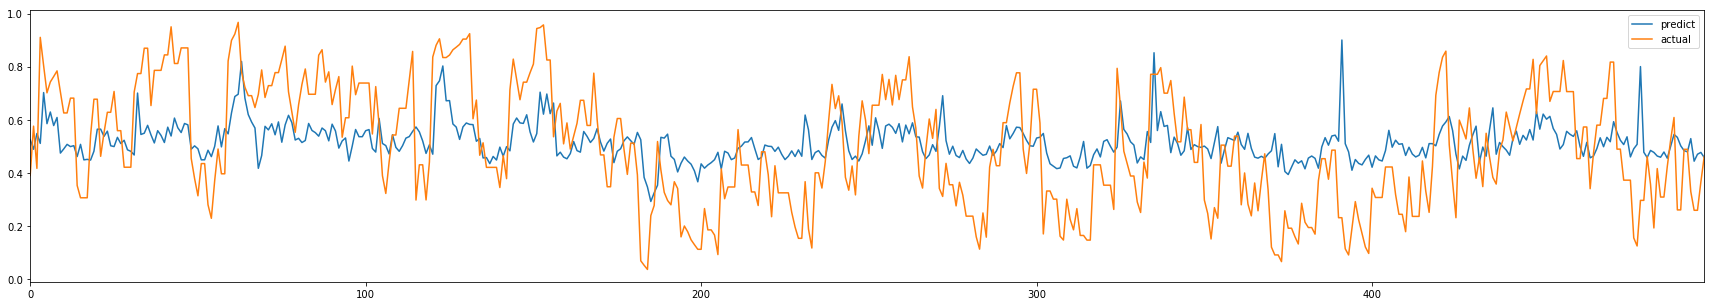

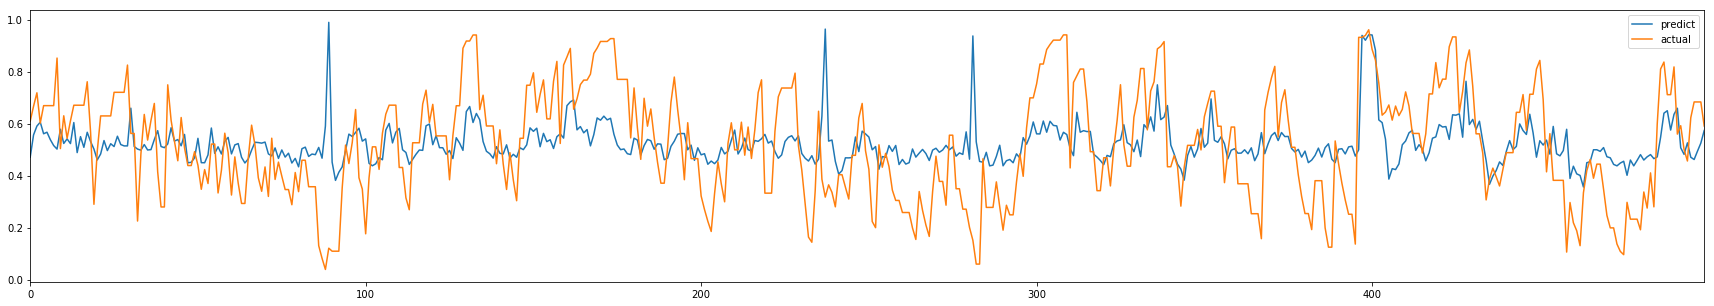

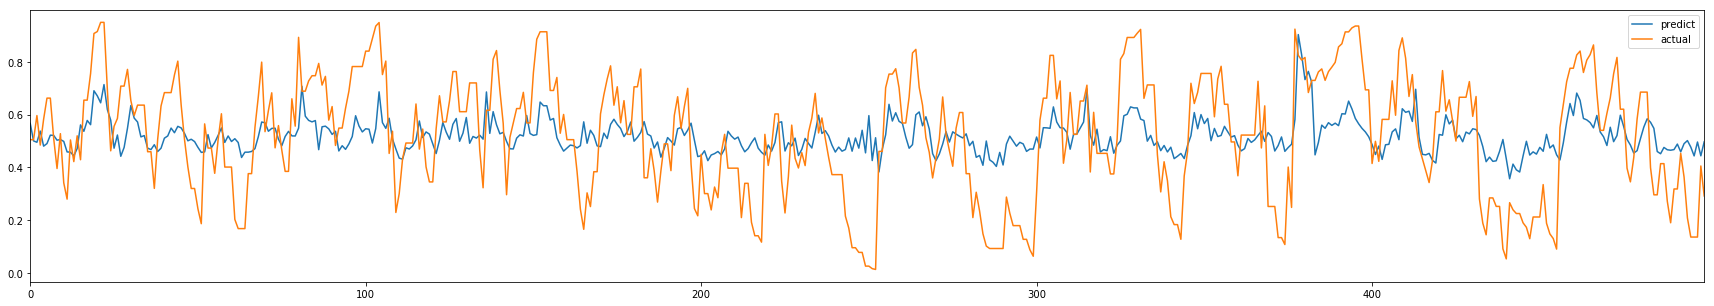

In [202]:
from keras.models import load_model
from keras.backend import clear_session
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import tensorflow as tf
from keras import backend as K
from redisai import model as raimodel
from redisai import Client, Tensor, Tensor, DType, Device, Backend, BlobTensor

# 学習済みモデルのロード
symbolname, ext = os.path.splitext(os.path.basename(csvfile))
model_file = os.path.join(MODEL_DIR, f"{symbolname}.h5")
model = load_model(model_file)

# 予測結果と実際の結果が正しいか確認してみる
start = len(test_Y) - 5000
for i in range(10):
    end = start + 500
    result = pd.DataFrame(model.predict(test_X[start:end]))
    result.columns = ['predict']
    result['actual'] = test_Y[start:end]
    result.plot(figsize=(30, 5))
    start += 500
    
# RedisAIにインポートするためにfrozen graph形式に変換
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

# Frozen Graphの作成
frozen_graph = freeze_session(
    K.get_session(),
    output_names=[out.op.name for out in model.outputs]
)

# RedisAIにモデルをロードする
inputs = [ inp.op.name for inp in model.inputs]
outputs = [out.op.name for out in model.outputs]
model_name, ext = os.path.splitext(os.path.basename(model_file))
with tempfile.TemporaryDirectory() as dname:
    client = Client("redisai", decode_responses=False)
    client.delete(model_name)
    raim = raimodel.Model.load(
        tf.train.write_graph(
            frozen_graph,
            dname, "model.pb", 
            as_text=False
        )
    )
    client.modelset(model_name, Backend.tf,
            Device.cpu,
            input=inputs,
            output=outputs,
            data=raim)
    
# セッションのクリア
clear_session()